In this notebook, we try to answer the question: with an optimized discriminator, does the Rabi amplitude change with and without DRAG correction?

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [1]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

In [2]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 0
cbit = 0
num_qubits = 1
num_cbits = 1
weight = 1

qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
qubit_12_freq = qubit_01_freq + qubit_anharmonicty

[<IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>]


In [3]:
p12_amp = 0.24029996372238208 # 3rd Dec 23
# 0.23743549524170637

with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=160, amp=p12_amp/2, sigma=40, beta=2.0, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=160, amp=p12_amp, sigma=40, beta=2.0, name='p12'), drive_chan)

p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

In [4]:
with pulse.build(backend=backend, default_alignment='left') as meas_sched:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(-1.0*MHz, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.acquire(1440, ac_chan, mem_chan)
    pulse.play(pulse.GaussianSquare(amp=0.6,
                                    duration=1440,
                                    sigma=32,
                                    width=1312,
                                    angle=0.7650583861061049), meas_chan)
    pulse.delay(6560, meas_chan)
    
meas_gate = Gate('Measure', weight, [])

### Discriminator circs

In [5]:
ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.append(meas_gate, [qubit])
ground_circ.add_calibration(meas_gate, [qubit], meas_sched)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.append(meas_gate, [qubit])
first_excited_state_circ.add_calibration(meas_gate, [qubit], meas_sched)

second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(p12_gate, [qubit])
second_excited_state_circ.append(meas_gate, [qubit])
second_excited_state_circ.add_calibration(meas_gate, [qubit], meas_sched)
second_excited_state_circ.add_calibration(p12_gate, [qubit], p12_sched)

discrim_circs = qiskit.transpile([ground_circ, first_excited_state_circ, second_excited_state_circ], backend=backend)

## Amplitude w/o DRAG

In [16]:
amps = np.linspace(-1, 1, 75)

rabi_circs_wDRAG = []

rabi12_gate = Gate(r'Rabi Gate', weight, [])

for amp in amps:
    
    with pulse.build(backend=backend) as rabi12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_12_freq, drive_chan)
        pulse.play(pulse.Drag(duration=160, amp=amp, sigma=40, beta=2.0), drive_chan)

    rabi12_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi12_circ.x(qubit)
    rabi12_circ.append(rabi12_gate, [qubit])
    rabi12_circ.append(meas_gate, [qubit])
    rabi12_circ.add_calibration(meas_gate, [qubit], meas_sched)
    rabi12_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)
                   
    rabi_circs_wDRAG.append(rabi12_circ)
    
rabi_circs_wDRAG = qiskit.transpile(rabi_circs_wDRAG, backend=backend)

In [7]:
package = discrim_circs + rabi_circs_woDRAG + rabi_circs_wDRAG

NameError: name 'rabi_circs_woDRAG' is not defined

In [19]:
ampvdrag_job = backend.run(package, meas_level=1, meas_return='single', shots=2048)

In [6]:
ampvdrag_job = provider.backend.retrieve_job('cnr1648brwpg008j818g')

In [7]:
ampvdrag_data = DataAnalysis(experiment=ampvdrag_job, average=False, shots=2048, qubit=0)
ampvdrag_data.retrieve_data(average=False)
ampvdrag_data.build_discrim()
ampvdrag_data.count_pop()
ampvdrag_data.error_mitiq()

In [ ]:
ampvdrag_data.mitiq_data[int(75+3):int(75+3+75), 0]

In [14]:
state0_withDRAG = ampvdrag_data.mitiq_data[int(75+3):int(75+3+75), 0]
state1_withDRAG = ampvdrag_data.mitiq_data[int(75+3):int(75+3+75), 1]
state2_withDRAG = ampvdrag_data.mitiq_data[int(75+3):int(75+3+75), 2]

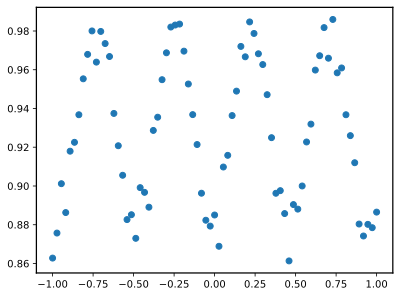

In [21]:
plt.scatter(amps, state2_withDRAG)